In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/step4_forecasting.csv', parse_dates=['Time'], index_col='Time')
df.head()

,GDP_growth,Spending_to_GDP_diff,Unemployment_diff,Rent_income_diff,Inflation_diff,PPI_diff_2
Time,,,,,,
1997-12-31,4.487859,-1.155073,-0.7,-0.016114,1.25167,-1.94017
1998-03-31,4.855286,-1.078558,-0.5,-0.024101,0.98445,-2.10186
1998-06-30,4.095967,-1.002043,-0.5,-0.027875,1.08290,-0.88027
1998-09-30,4.097735,-0.925527,-0.3,-0.025923,1.08290,-0.55690
1998-12-31,4.879111,-0.849012,-0.3,-0.016616,1.05477,-0.26948


In [3]:
df.tail()

,GDP_growth,Spending_to_GDP_diff,Unemployment_diff,Rent_income_diff,Inflation_diff,PPI_diff_2
Time,,,,,,
2022-03-31,0.920880,2.665047,-2.246047,0.163760,-13.509874,-55.856995
2022-06-30,-20.648619,3.369267,7.888470,0.059798,33.561886,61.554821
2022-09-30,-19.371290,-2.193077,18.970973,-0.132736,16.847659,-15.237112
2022-12-31,-11.233414,6.548380,18.920030,0.019829,-70.927469,-309.620505
2023-03-31,-110.519393,25.082723,37.902953,0.692571,-33.955285,-79.432652


In [4]:
import joblib
filepath = 'models/var_model.pkl'
results = joblib.load(filepath)

## Evaluation - Forecast error variance decomposition (FEVD)
Indicate the amount of information each variable contributes to the other variables in autoregression.
Determine how much of the forecast error variance of each of the variables can be explained by exogenous shocks to other variables.

Test for forecast errors in the impulse response function.

The summary below shows that the forecast errors on GDP growth most likely will be coming from itself, followed by unemployment, then inflation or government spending to GDP.

In [5]:
# forecast steps
forecast_steps = 8

In [6]:
# decompose forecast errors of components with steps ahead
fevd = results.fevd(forecast_steps)
fevd.summary()

FEVD for GDP_growth
     GDP_growth  Spending_to_GDP_diff  Unemployment_diff  Rent_income_diff  Inflation_diff  PPI_diff_2
0      1.000000              0.000000           0.000000          0.000000        0.000000    0.000000
1      0.968181              0.002702           0.016125          0.003038        0.009954    0.000000
2      0.858026              0.002989           0.102566          0.021371        0.015048    0.000000
3      0.817643              0.063195           0.099412          0.013462        0.006288    0.000000
4      0.830714              0.070067           0.063785          0.011868        0.023566    0.000000
5      0.769835              0.066011           0.089410          0.022449        0.052296    0.000000
6      0.732179              0.064685           0.121298          0.021144        0.060694    0.000000
7      0.743930              0.124775           0.061089          0.039123        0.031083    0.000000

FEVD for Spending_to_GDP_diff
     GDP_growth  Spend

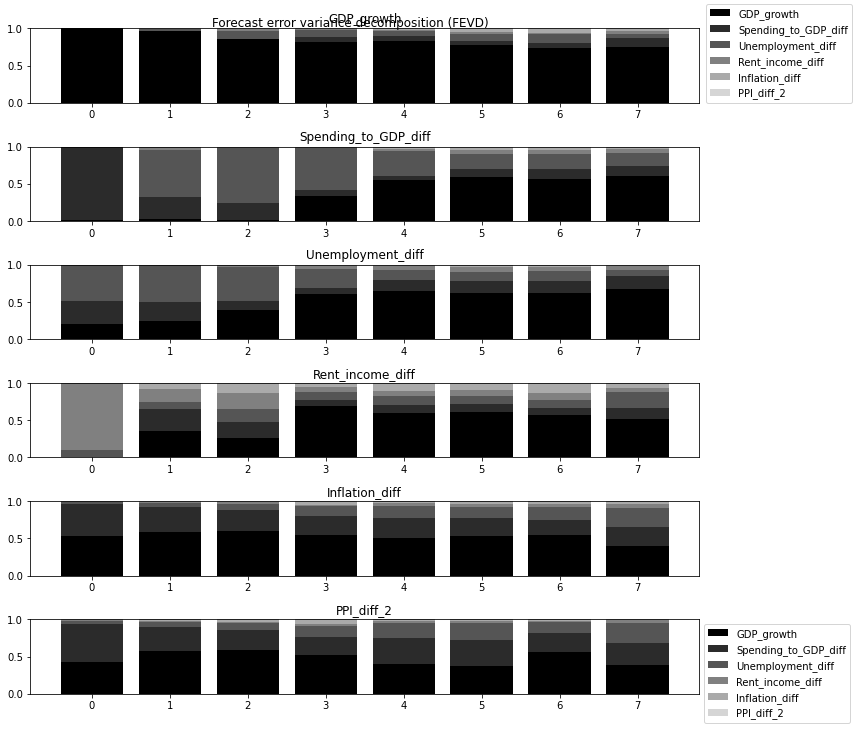

In [7]:
results.fevd(forecast_steps).plot()
plt.tight_layout()
plt.legend(bbox_to_anchor=(1,1))
plt.show()

## Inverting
Invert transformed data back to its original form

In [8]:
df_train, df_test = df[0:-forecast_steps], df[-forecast_steps:]

In [9]:
pred = results.forecast(results.y, steps=forecast_steps)
df_forecast = pd.DataFrame(pred, index=df.index[-forecast_steps:], columns=df.columns+'_fc')
df_forecast.tail()

,GDP_growth_fc,Spending_to_GDP_diff_fc,Unemployment_diff_fc,Rent_income_diff_fc,Inflation_diff_fc,PPI_diff_2_fc
Time,,,,,,
2022-03-31,5.891302,-1.040001,-3.161682,-0.067553,7.109630,26.660500
2022-06-30,11.388645,-3.012601,-5.838980,-0.038296,4.907745,32.394860
2022-09-30,11.936260,-3.887675,-6.759768,-0.006298,-1.585259,3.836944
2022-12-31,3.813357,-2.406211,-2.910463,0.063746,-1.379739,-19.487115
2023-03-31,-3.751944,0.464628,2.483526,0.016936,5.936078,-25.370341


In [10]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        if second_diff:
            df_fc[str(col)+'_fc'] = (df_train[col].iloc[-4] - df_train[col].iloc[-8]) + df_fc[str(col)+'_fc'].cumsum()
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-4] + df_fc[str(col)+'_fc'].cumsum()
    return df_fc

In [11]:
df_train.tail()

,GDP_growth,Spending_to_GDP_diff,Unemployment_diff,Rent_income_diff,Inflation_diff,PPI_diff_2
Time,,,,,,
2020-03-31,0.319261,0.246119,0.6,0.011520,2.2606,-1.8144
2020-06-30,-9.032775,0.164079,7.5,-0.079694,0.3934,-6.1079
2020-09-30,-2.848345,0.082040,4.3,-0.039605,1.3235,-0.9701
2020-12-31,-2.386694,0.000000,3.1,-0.020867,1.3449,-0.0180
2021-03-31,0.406168,0.000000,1.6,-0.136863,2.0686,5.3175


In [12]:
df.tail()

,GDP_growth,Spending_to_GDP_diff,Unemployment_diff,Rent_income_diff,Inflation_diff,PPI_diff_2
Time,,,,,,
2022-03-31,0.920880,2.665047,-2.246047,0.163760,-13.509874,-55.856995
2022-06-30,-20.648619,3.369267,7.888470,0.059798,33.561886,61.554821
2022-09-30,-19.371290,-2.193077,18.970973,-0.132736,16.847659,-15.237112
2022-12-31,-11.233414,6.548380,18.920030,0.019829,-70.927469,-309.620505
2023-03-31,-110.519393,25.082723,37.902953,0.692571,-33.955285,-79.432652


In [13]:
df_gdp_forecast = df_forecast.iloc[:, :1]
df_gdp_forecast.reset_index(inplace=True)
df_gdp_forecast

,Time,GDP_growth_fc
0,2021-06-30,3.044324
1,2021-09-30,1.236768
2,2021-12-31,-0.709559
3,2022-03-31,5.891302
4,2022-06-30,11.388645
5,2022-09-30,11.936260
6,2022-12-31,3.813357
7,2023-03-31,-3.751944


In [14]:
df_results_1d = invert_transformation(df_train, df_forecast)
df_results_1d = df_results_1d.iloc[:, -5:-1].reset_index()
df_results_1d

,Time,Spending_to_GDP_diff_forecast,Unemployment_diff_forecast,Rent_income_diff_forecast,Inflation_diff_forecast
0,2021-06-30,0.304610,8.065243,-0.106711,-0.253518
1,2021-09-30,0.995783,8.439629,-0.109911,-2.062504
2,2021-12-31,1.776458,7.852496,-0.131215,-0.224370
3,2022-03-31,0.736458,4.690814,-0.198767,6.885260
4,2022-06-30,-2.276143,-1.148166,-0.237064,11.793005
5,2022-09-30,-6.163818,-7.907934,-0.243362,10.207746
6,2022-12-31,-8.570030,-10.818397,-0.179616,8.828006
7,2023-03-31,-8.105402,-8.334871,-0.162680,14.764085


In [15]:
df_results_2d = invert_transformation(df_train, df_forecast, second_diff=True)
df_results_2d = df_results_2d.iloc[:, -1:].reset_index()
df_results_2d

,Time,PPI_diff_2_forecast
0,2021-06-30,-20.160563
1,2021-09-30,-45.921510
2,2021-12-31,-67.260160
3,2022-03-31,-61.938310
4,2022-06-30,-24.221601
5,2022-09-30,17.332052
6,2022-12-31,39.398590
7,2023-03-31,36.094787


In [16]:
df_results = df_gdp_forecast.merge(df_results_1d, how='inner', on='Time')
df_results = df_results.merge(df_results_2d, how='inner', on='Time')
df_results['Time'] = pd.to_datetime(df_results['Time'], format='%Y-%m-%d')
df_results.set_index('Time', inplace=True)
df_results

,GDP_growth_fc,Spending_to_GDP_diff_forecast,Unemployment_diff_forecast,Rent_income_diff_forecast,Inflation_diff_forecast,PPI_diff_2_forecast
Time,,,,,,
2021-06-30,3.044324,0.304610,8.065243,-0.106711,-0.253518,-20.160563
2021-09-30,1.236768,0.995783,8.439629,-0.109911,-2.062504,-45.921510
2021-12-31,-0.709559,1.776458,7.852496,-0.131215,-0.224370,-67.260160
2022-03-31,5.891302,0.736458,4.690814,-0.198767,6.885260,-61.938310
2022-06-30,11.388645,-2.276143,-1.148166,-0.237064,11.793005,-24.221601
2022-09-30,11.936260,-6.163818,-7.907934,-0.243362,10.207746,17.332052
2022-12-31,3.813357,-8.570030,-10.818397,-0.179616,8.828006,39.398590
2023-03-31,-3.751944,-8.105402,-8.334871,-0.162680,14.764085,36.094787


## Plotting forecast

In [17]:
def plot_forecast(df_col, fc_col, title):
    plt.plot(df[df_col][:-forecast_steps].append(df_results[fc_col]), color='orange', linestyle='--', alpha=0.8)
    plt.plot(df[df_col][:-forecast_steps], color='cornflowerblue')
    plt.title(title)
    plt.show()

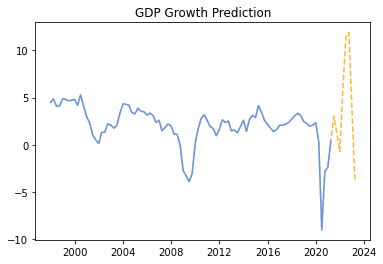

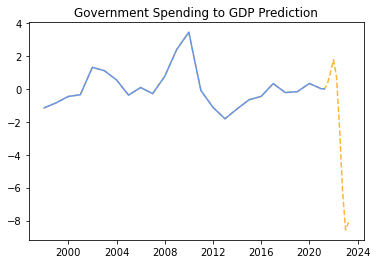

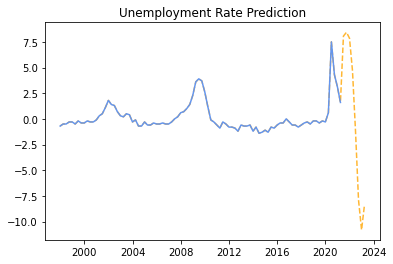

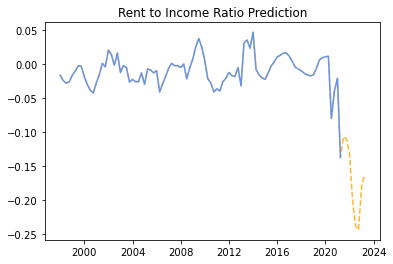

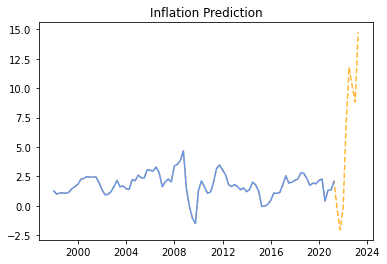

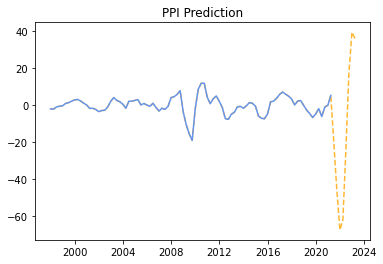

In [18]:
series1 = ['GDP_growth', 'Spending_to_GDP_diff', 'Unemployment_diff', 'Rent_income_diff', 'Inflation_diff', 'PPI_diff_2']
series2 = ['GDP_growth_fc', 'Spending_to_GDP_diff_forecast', 'Unemployment_diff_forecast', 'Rent_income_diff_forecast', 'Inflation_diff_forecast', 'PPI_diff_2_forecast']
title = ['GDP Growth Prediction', 'Government Spending to GDP Prediction', 'Unemployment Rate Prediction', 'Rent to Income Ratio Prediction', 'Inflation Prediction', 'PPI Prediction']

for a, b, c in zip(series1, series2, title):
    plot_forecast(a, b, c)

## Conclusion

Here is the takeaway from our analysis:

1. As shown in the heatmap, unemployment rate has the highest correlation with GDP growth, whereas rent to income ratio has the lowest correlation with GDP growth.

2. From impulse response analysis, rent to income ratio has a huge effect on GDP growth.

3. From forecast error variance decomposition (FEVD), standard error of GDP growth forecast most likely won't be contributed by producer price indices (PPI), meaning PPI has little effect on the forecast.

4. From Johansen test, we may only need 2 variables from our dataset to make the existing time series cointegrated.

In conclusion, I can say that unemployment rate is always in the same conversation with GDP growth. GDP growth may be explained by inflation, government spending and producer price indices, but not too relevant with rent to income ratio.

### Further work

We used 5 variables to predict GDP Growth. They are unemployment rate, government spending to GDP ratio, inflation, producer price indice, and rent to income ratio.

We may have a better result with 2 immediate approaches.

First, based on the results we obtained from Johansen test for cointegration, we can eliminate all columns but 1-2 most significant ones along with the GDP growth, which is our target variable. This would in turn have less unnecessary effect or noise for our prediction. 

Second, we can replace the most insignificant variables with other variables to see the new predictive power, as we have already found out some of them have little effect on GDP growth.

Doing so may result in a better forecast immediately.

Going forward, we can also use the same approach to test the other countries of our choice. We may even find surprising results and foretell an upcoming market crash.